In [1]:
import os
from solcx import compile_files, install_solc, get_installed_solc_versions
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to extract the pragma version from a Solidity file, defaulting to 0.4.23
def extract_solidity_version(file_path):
    pragma_pattern = re.compile(r'pragma solidity (\^?)(\d+\.\d+\.\d+);')
    with open(file_path, 'r') as file:
        for line in file:
            pragma_match = pragma_pattern.search(line)
            if pragma_match:
                # Ignore the range indicator and return the version part
                return pragma_match.group(2)
    # Return default version if no pragma is found
    return '0.4.23'


total = 1426
# Function to traverse directories and process .sol files
def process_directory(parent_directory):
    #total_files = sum(len(files) for _, _, files in os.walk(parent_directory) if any(file.endswith('.sol') for file in files))
    asts = {}  
    processed_files = 0  # Counter for the number of files processed into ASTs

    i = 1
    for root, dirs, files in os.walk(parent_directory):
        subdirectory = os.path.relpath(root, parent_directory)
        for filename in files:
            if filename.endswith('.sol'):
                file_path = os.path.join(root, filename)
                print(f"Converting Solidity Files to AST : {i}/{total}", end="\r", flush=True)
                i += 1

                sol_version = extract_solidity_version(file_path)

                if sol_version not in get_installed_solc_versions():
                    install_solc(sol_version)

                compiled_sol = compile_files([file_path], solc_version=sol_version, output_values=["ast"])

                if subdirectory not in asts:
                    asts[subdirectory] = {}

                for contract_name, compiled_data in compiled_sol.items():
                    if 'ast' in compiled_data:
                        asts[subdirectory][contract_name] = compiled_data['ast']
                        processed_files += 1  # Increment only when an AST is successfully added

    print("")
    print(f"Total files processed: {i - 1}")
    print(f"ASTs successfully added: {processed_files}")
    return asts
def flatten(ast, current_key=None): #Flatten the AST into a single list of [node:value] pairs
    node_list = []

    if isinstance(ast, list):
        for item in ast:
            node_list.extend(flatten(item, current_key))
    elif isinstance(ast, dict):
        for key, value in ast.items():
            node_list.extend(flatten(value, key))
    else:
        node_list.append((current_key, ast))

    return node_list

def get_number_of_common_nodes(ast_a, ast_b): #Get common nodes between 2 flattened asts
    nodes_a = flatten(ast_a)
    nodes_b = flatten(ast_b)
    
    common_nodes = [node for node in nodes_a if node in nodes_b]
    return len(common_nodes)

def build_feature_vector(asts, ast, class_of_ast, ast_name, total_asts,j):
    i=0
    features = {}
    for class_name, contracts in asts.items():
        common_sub_nodes = 0
        count = 0
        for contract_name, contract_ast in contracts.items():
            if contract_name == ast_name:
                continue
            common_sub_nodes += get_number_of_common_nodes(ast, contract_ast)
            count += 1
        if count > 0:
            features[class_name] = common_sub_nodes / count
        else:
            features[class_name] = 0
            
    features["class"] = class_of_ast
    return features


In [3]:
# Define the parent directory containing subdirectories with .sol files
parent_directory = 'dataset'  # Update this to your parent directory
asts = process_directory(parent_directory)

# Output the loaded contracts and their ASTs organized by subdirectory
print("\n\n----------\n")
print("Contracts and their ASTs loaded")

#asts = {class: {
#                         "CONTRACT NAME":  {AST1},
#                         "CONTRACT NAME2": {AST2},
#                         ...}, 
#               {...}
#                          
#}


Converting Solidity Files to AST : 1426/1426
Total files processed: 1426
ASTs successfully added: 1777


----------

Contracts and their ASTs loaded


In [6]:
print("Building feature vectors (this will take some time :(")
cols = []
for class_name,contracts in asts.items():
    cols.append(class_name)
cols.append('class')
        
total_asts = 1777
df = pd.DataFrame(columns = cols)
df
i = 0
#NOTE: @THIS TAKES 7+ HOURS@
for class_name,contracts in asts.items():
    print(f"Turning {class_name} ASTs into feature vector...")
    for contract_name, contract_ast in contracts.items():
        feature = build_feature_vector(asts,contract_ast,class_name,contract_name,total_asts,i)
        i+=1
        feature_df = pd.DataFrame([feature])
        df = pd.concat([df, feature_df], ignore_index=True)  # Concatenate
print("Finished building feature vectors!")

Building feature vectors (this will take some time :(
Turning safe ASTs into feature vector...
Turning reentrancy ASTs into feature vector...
Turning unchecked_low_level_calls ASTs into feature vector...
Turning denial_of_service ASTs into feature vector...
Turning access_control ASTs into feature vector...
Turning arithmetic ASTs into feature vector...
Turning time_manipulation ASTs into feature vector...
Finished building feature vectors!


In [56]:
# Splitting the features and target variable
y = df['class']
X = df.drop('class', axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Transform the features

# Convert scaled data back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42)  # 30% test size

# Initializing and training the KNN model
knn = KNeighborsClassifier(n_neighbors=8)  # 8 neighbors
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

Classification Report:
                           precision    recall  f1-score   support

           access_control       0.79      0.65      0.71        17
               arithmetic       0.49      0.53      0.51       113
        denial_of_service       0.88      0.83      0.86        18
               reentrancy       0.63      0.68      0.65       121
                     safe       0.72      0.68      0.70        41
        time_manipulation       0.69      0.71      0.70       143
unchecked_low_level_calls       0.94      0.73      0.82        81

                 accuracy                           0.67       534
                macro avg       0.73      0.69      0.71       534
             weighted avg       0.68      0.67      0.67       534

Confusion Matrix:
[[ 11   3   0   2   0   0   1]
 [  0  60   0  25   0  28   0]
 [  1   0  15   0   0   2   0]
 [  1  24   0  82   2  10   2]
 [  1   1   0   9  28   1   1]
 [  0  32   2   8   0 101   0]
 [  0   3   0   5   9   5  59]]


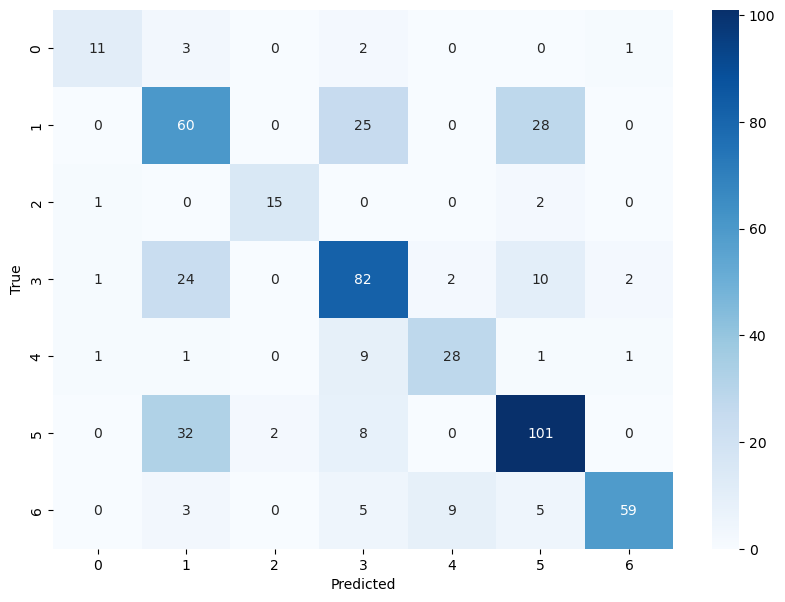

In [57]:
# Making predictions
y_pred = knn.predict(X_test)

# Evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

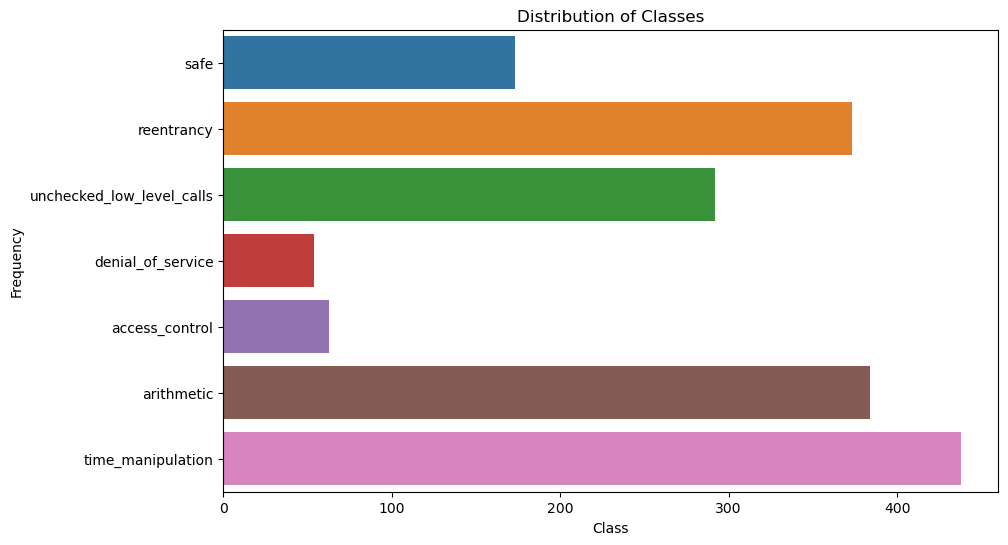

In [58]:
# Plotting distribution of the classes
plt.figure(figsize=(10, 6))
sns.countplot(y=df['class'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

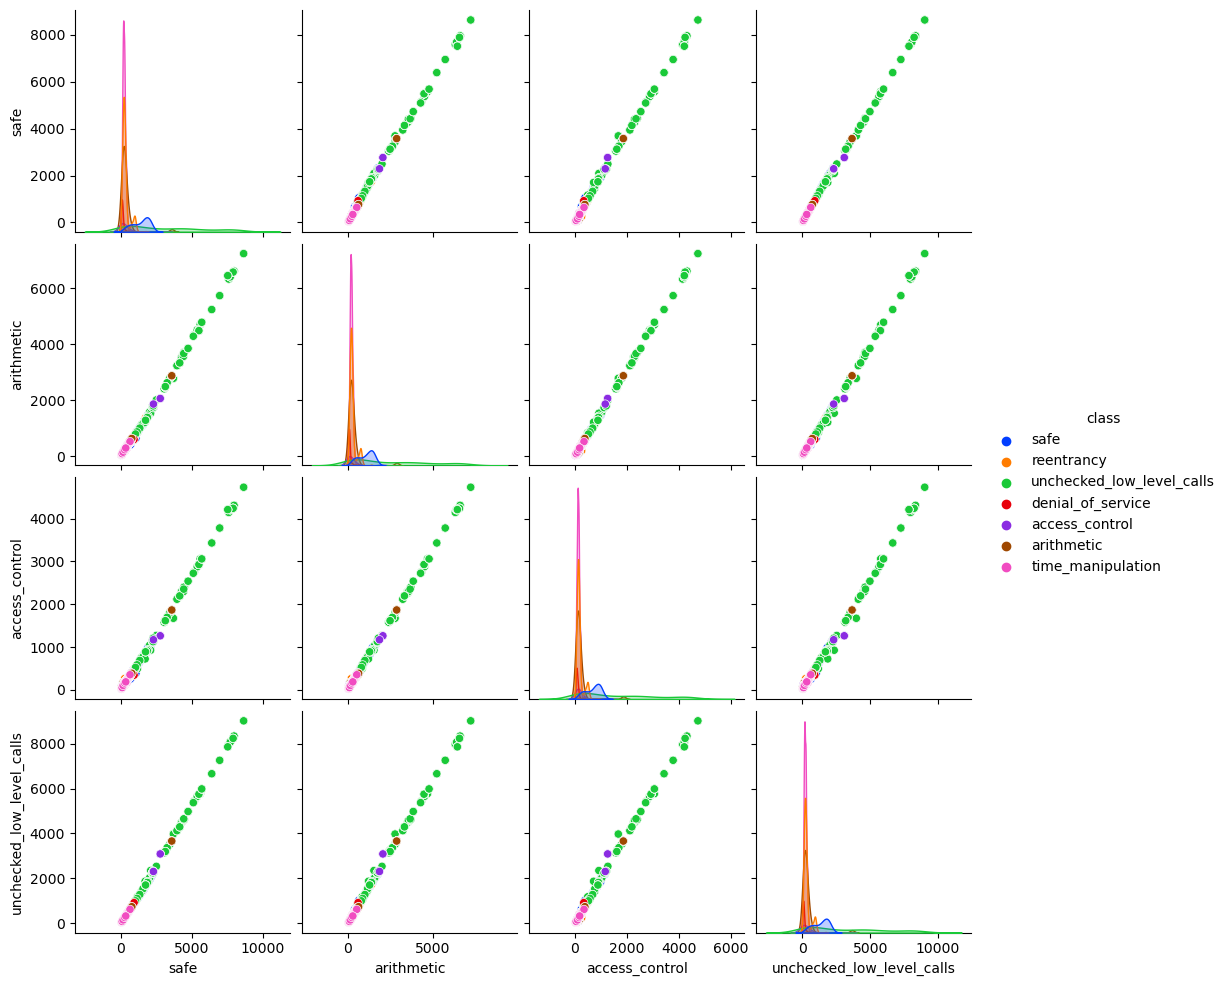

In [59]:
# Pairplot of some selected features colored by class
# Selecting a subset of features for clearer visualization
features = ['safe', 'arithmetic', 'access_control', 'unchecked_low_level_calls']  
sns.pairplot(df[features + ['class']], hue='class', palette='bright')

sns.pairplot
plt.show()

IndexError: list index out of range

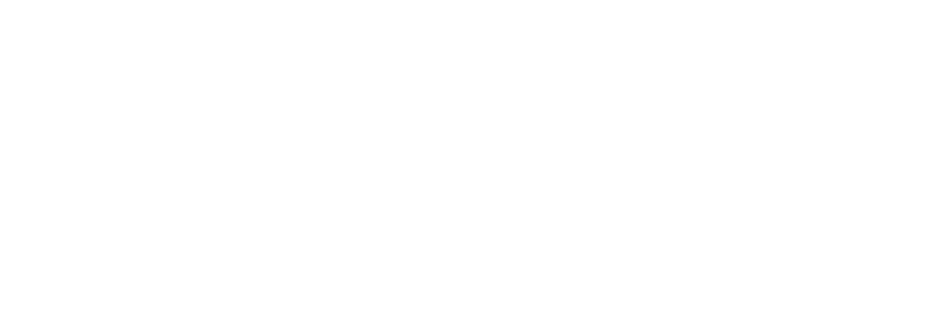

In [65]:
import matplotlib.pyplot as plt

# Classification results
results = {
    'Class': ['access_control', 'arithmetic', 'denial_of_service', 'reentrancy', 
              'safe', 'time_manipulation', 'unchecked_low_level_calls', 'Accuracy', 'Macro Avg', 'Weighted Avg'],
    'Precision': [0.92, 0.50, 0.93, 0.61, 0.73, 0.71, 0.87, '', 0.75, 0.68],
    'Recall': [0.65, 0.53, 0.78, 0.67, 0.66, 0.73, 0.74, 0.67, 0.68, 0.67],
    'F1-Score': [0.76, 0.51, 0.85, 0.64, 0.69, 0.72, 0.80, '', 0.71, 0.67],
    'Support': [17, 113, 18, 121, 41, 143, 81, 534, 534, 534]
}

# Set up figure
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_frame_on(False)  # No visible frame
ax.xaxis.set_visible(False)  # Hide the x axis
ax.yaxis.set_visible(False)  # Hide the y axis

# Create table and scale it to the figure
the_table = plt.table(cellText=[results[key] for key in results],
                      colLabels=list(results.keys()),
                      colColours=["#F3CC32"] * len(results['Class']),  # Change the colors if you want
                      cellLoc = 'center', 
                      loc='center')

# Scale table to fit figure
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.2)  # You might need to adjust these values

# Display the table
plt.show()
